In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [2]:
import os
from PIL import Image
import numpy as np

categories = os.listdir('./data/cards/train')

names_to_labels = dict()

training_images = []
training_labels = []

for i in range(len(categories)):
    names_to_labels[categories[i]] = i

for c in categories:
    files = os.listdir('./data/cards/train/' + c)
    for f in files:
        image = Image.open('./data/cards/train/' + c + '/' + f)
        image = image.resize((32,32))
        image = np.array(image) 

        training_images.append(transform(image))
        training_labels.append(names_to_labels[c])

In [4]:
categories = os.listdir('./data/cards/test')

names_to_labels = dict()

test_images = []
test_labels = []

for i in range(len(categories)):
    names_to_labels[categories[i]] = i

for c in categories:
    files = os.listdir('./data/cards/test/' + c)
    for f in files:
        image = Image.open('./data/cards/test/' + c + '/' + f)
        image = image.resize((32,32))
        image = np.array(image) 

        test_images.append(transform(image))
        test_labels.append(names_to_labels[c])

test_images = torch.stack(test_images)
test_labels = torch.tensor(test_labels)

In [5]:
print(len(training_images))
print(len(training_labels))

7624
7624


In [6]:
training_images = torch.stack(training_images)

In [7]:
training_labels = torch.tensor(training_labels)

In [8]:
test_images.shape 

torch.Size([265, 3, 32, 32])

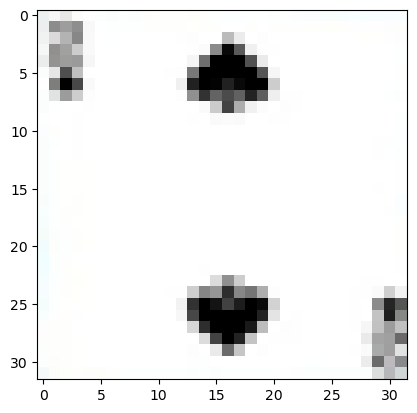

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
imshow(training_images[7623])

In [ ]:
from torch import nn, optim
from torch.functional import F

# Define the CNN model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(categories))  # Adjust the output size based on the number of categories

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
net = Net()

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
def train_iteration(num, batch):
    num_ex = num
    batch_size = batch
    for ex in range(num_ex):
        running_loss = 0.0
        for i in range(0, len(training_images), batch_size):
            # Get the inputs
            inputs = training_images[i:i+batch_size]
            labels = training_labels[i:i+batch_size]
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = net(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
        
        running_loss += loss.item()

def test_training_set():
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(len(training_images)):
            outputs = net(training_images[i].unsqueeze(0))
            _, predicted = torch.max(outputs.data, 1)
            total += 1
            correct += (predicted == training_labels[i]).sum().item()
    return (correct / total)

def test_testing_set():
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(len(test_images)):
            outputs = net(test_images[i].unsqueeze(0))
            _, predicted = torch.max(outputs.data, 1)
            total += 1
            correct += (predicted == test_labels[i]).sum().item()
    return (correct / total) 

In [ ]:
epoch = []
trainacc = []
testacc = []
ep = 10
for i in range(40):
    train_iteration(5, 20)
    tracc = test_training_set()
    teacc = test_testing_set()
    print(f"Training set accuracy: {tracc}, Testing set accuracy: {teacc}")
    epoch.append((i * 1) * ep)
    trainacc.append(tracc)
    testacc.append(teacc)

In [ ]:
import pandas as pd
df = pd.DataFrame({"Epoch" : epoch, "Training Accuracy" : trainacc, "Testing Accuracy" : testacc})
df.to_excel("training_values_by_epoch.xlsx", index = False)
display(df)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

#plot value1

plt.plot(df['Epoch'], df['Training Accuracy'], label= 'Training Accuracy', color = 'blue')

#plot value2

plt.plot(df['Epoch'], df['Testing Accuracy'], label= 'Testing Accuracy', color = 'red')

# add labels and titles

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Cards classfier Testing and Training Accuracy v.s, Training Epochs')

#add a legend
plt.legend()

#display the plot
plt.show()

In [ ]:
!pip install matplotlib

In [ ]:
# Save the trained model
torch.save(net.state_dict(), 'cardsclass_cnn_82024_1.pth')

# Testing (on the same dataset for simplicity)
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(training_images)):
        outputs = net(training_images[i].unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += (predicted == training_labels[i]).sum().item()

print(f'Accuracy of the network on the training images: {100 * correct / total:.2f}%')

In [ ]:
# Testing (on the same dataset for simplicity)
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(test_images)):
        outputs = net(test_images[i].unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        total += 1
        correct += (predicted == test_labels[i]).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')